In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Adam = optimizers.Adam(lr=0.001)

In [2]:
csv_path_train = 'testset/J0003_0024_0221_20110307012732_cell_18.csv'
csv_path_test = 'testset/J0003_0024_0221_20110307012732_cell_03.csv'
df = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

date_time = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
date_time_test = pd.to_datetime(df_test.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')

In [3]:
df.head()

,CellNo,Resistance,Volt,Temp
0,18,0.398,2.3,-20
1,18,0.398,2.3,-20
2,18,0.401,2.3,-20
3,18,0.402,2.3,-20
4,18,0.402,2.3,-20


In [4]:
df_test.head()

,CellNo,Resistance,Volt,Temp
0,3,0.298,2.23,-20
1,3,0.298,2.23,-20
2,3,0.297,2.24,-20
3,3,0.299,2.23,-20
4,3,0.298,2.24,-20


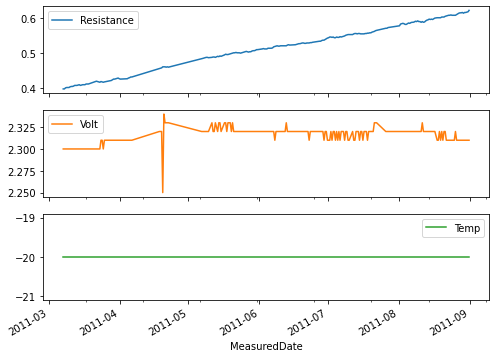

In [5]:
plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


array([<AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>], dtype=object)

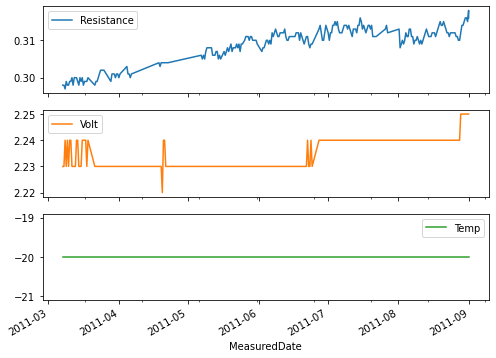

In [6]:
#plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features_test = df_test[plot_cols]
plot_features_test.index = date_time_test
plot_features_test.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CellNo,252.0,18.000000,0.000000,18.000,18.000,18.0000,18.0000,18.000
Resistance,252.0,0.520369,0.063384,0.398,0.488,0.5255,0.5665,0.622
Volt,252.0,2.315913,0.009035,2.250,2.310,2.3200,2.3200,2.340
Temp,252.0,-20.000000,0.000000,-20.000,-20.000,-20.0000,-20.0000,-20.000


In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices = {name: i for i, name in enumerate(df_test.columns)}

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df[plot_cols])
df_test = scaler.fit_transform(df_test[plot_cols])
df = pd.DataFrame(df)
df_test = pd.DataFrame(df_test)
df.columns = plot_cols
df_test.columns = plot_cols

In [10]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.8)]
test_df = df[int(n*0.8):]
#n_test = len(df_test)
test_df_test = df_test[:int(n*0.7)]
label_df = df_test[int(n*0.7):]

num_features = df.shape[1]
#print(int(n*0.8),int(n*0.2),len(test_df), len(label_df))

In [11]:
df.head()

,Resistance,Volt,Temp
0,0.000000,0.555556,0.0
1,0.000000,0.555556,0.0
2,0.013393,0.555556,0.0
3,0.017857,0.555556,0.0
4,0.017857,0.555556,0.0


<AxesSubplot:>

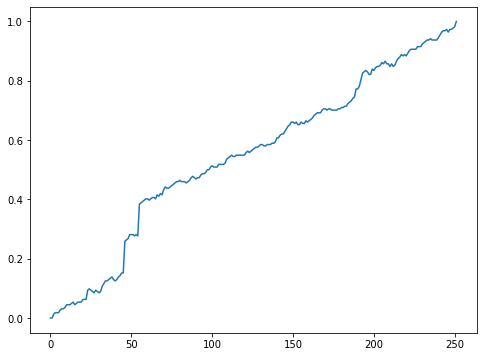

In [12]:
df['Resistance'].plot()

In [13]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [14]:
#w1 = WindowGenerator(input_width = 28, label_width=28, shift=1, label_columns = ['Resistance'])
#w1

In [15]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def plot(self, model=None, plot_col='Resistance', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    max_n=1
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(self.label_indices, labels[n, :, label_col_index], label='Labels', c='#2ca02c', zorder=-10)
                #edgecolors='k', c='#2ca02c', s=1)
        if model is not None:
            predictions = model(inputs)
            plt.plot(self.label_indices, predictions[n, :, label_col_index], label='Predictions', c='#ff7f0e', zorder=-10)
                   
             #           edgecolors='k', label='Predictions',
              #    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [17]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets = None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

def test_test(self):
    return self.make_dataset(self.test_df_test)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.test_test = test_test

Total window size: 174
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
Label indices: [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173]
Label column name(s): None

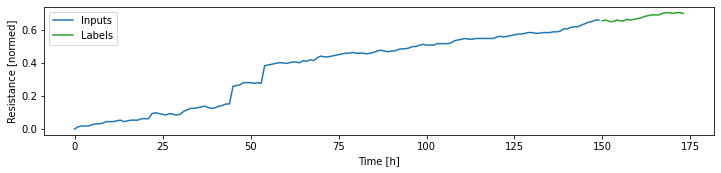

In [19]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=150,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

In [20]:
MAX_EPOCHS = 1500

def compile_and_fit(model, window, patience=500):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    # optimizer=tf.optimizers.Adam(),
                    optimizer=Adam,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [21]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(32, activation='relu', kernel_initializer='he_normal', dropout=0.1, return_sequences=False),
    # tf.keras.layers.Dropout(rate=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [22]:
history = compile_and_fit(model, multi_window)

Epoch 1/1500
1/1 [==============================] - 5s 5s/step - loss: 0.3340 - mean_absolute_error: 0.4707
Epoch 2/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.3300 - mean_absolute_error: 0.4679
Epoch 3/1500
1/1 [==============================] - 0s 114ms/step - loss: 0.3257 - mean_absolute_error: 0.4649
Epoch 4/1500
1/1 [==============================] - 0s 119ms/step - loss: 0.3212 - mean_absolute_error: 0.4616
Epoch 5/1500
1/1 [==============================] - 0s 113ms/step - loss: 0.3163 - mean_absolute_error: 0.4580
Epoch 6/1500
1/1 [==============================] - 0s 120ms/step - loss: 0.3109 - mean_absolute_error: 0.4541
Epoch 7/1500
1/1 [==============================] - 0s 112ms/step - loss: 0.3051 - mean_absolute_error: 0.4498
Epoch 8/1500
1/1 [==============================] - 0s 117ms/step - loss: 0.2988 - mean_absolute_error: 0.4451
Epoch 9/1500
1/1 [==============================] - 0s 99ms/step - loss: 0.2918 - mean_absolute_error: 0.4399
Epoch

Epoch 34/1500
1/1 [==============================] - 0s 109ms/step - loss: 0.0025 - mean_absolute_error: 0.0370
Epoch 35/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0040 - mean_absolute_error: 0.0435
Epoch 36/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0056 - mean_absolute_error: 0.0548
Epoch 37/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0072 - mean_absolute_error: 0.0640
Epoch 38/1500
1/1 [==============================] - 0s 101ms/step - loss: 0.0085 - mean_absolute_error: 0.0708
Epoch 39/1500
1/1 [==============================] - 0s 109ms/step - loss: 0.0094 - mean_absolute_error: 0.0752
Epoch 40/1500
1/1 [==============================] - 0s 107ms/step - loss: 0.0099 - mean_absolute_error: 0.0773
Epoch 41/1500
1/1 [==============================] - 0s 98ms/step - loss: 0.0099 - mean_absolute_error: 0.0773
Epoch 42/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0094 - mean_absolute_error: 0

Epoch 67/1500
1/1 [==============================] - 0s 136ms/step - loss: 0.0015 - mean_absolute_error: 0.0273
Epoch 68/1500
1/1 [==============================] - 0s 138ms/step - loss: 0.0013 - mean_absolute_error: 0.0260
Epoch 69/1500
1/1 [==============================] - 0s 121ms/step - loss: 0.0012 - mean_absolute_error: 0.0245
Epoch 70/1500
1/1 [==============================] - 0s 109ms/step - loss: 0.0011 - mean_absolute_error: 0.0230
Epoch 71/1500
1/1 [==============================] - 0s 126ms/step - loss: 0.0010 - mean_absolute_error: 0.0214
Epoch 72/1500
1/1 [==============================] - 0s 110ms/step - loss: 9.4757e-04 - mean_absolute_error: 0.0198
Epoch 73/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.9584e-04 - mean_absolute_error: 0.0182
Epoch 74/1500
1/1 [==============================] - 0s 118ms/step - loss: 8.6397e-04 - mean_absolute_error: 0.0171
Epoch 75/1500
1/1 [==============================] - 0s 120ms/step - loss: 8.4998e-04 - mean

1/1 [==============================] - 0s 100ms/step - loss: 8.5139e-04 - mean_absolute_error: 0.0168
Epoch 100/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.5427e-04 - mean_absolute_error: 0.0170
Epoch 101/1500
1/1 [==============================] - 0s 134ms/step - loss: 8.5648e-04 - mean_absolute_error: 0.0171
Epoch 102/1500
1/1 [==============================] - 0s 170ms/step - loss: 8.5779e-04 - mean_absolute_error: 0.0172
Epoch 103/1500
1/1 [==============================] - 0s 139ms/step - loss: 8.5813e-04 - mean_absolute_error: 0.0172
Epoch 104/1500
1/1 [==============================] - 0s 135ms/step - loss: 8.5754e-04 - mean_absolute_error: 0.0172
Epoch 105/1500
1/1 [==============================] - 0s 110ms/step - loss: 8.5616e-04 - mean_absolute_error: 0.0171
Epoch 106/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.5422e-04 - mean_absolute_error: 0.0169
Epoch 107/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.51

1/1 [==============================] - 0s 95ms/step - loss: 8.4216e-04 - mean_absolute_error: 0.0161
Epoch 132/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4214e-04 - mean_absolute_error: 0.0161
Epoch 133/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4216e-04 - mean_absolute_error: 0.0161
Epoch 134/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4223e-04 - mean_absolute_error: 0.0161
Epoch 135/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.4230e-04 - mean_absolute_error: 0.0161
Epoch 136/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.4238e-04 - mean_absolute_error: 0.0161
Epoch 137/1500
1/1 [==============================] - 0s 135ms/step - loss: 8.4244e-04 - mean_absolute_error: 0.0161
Epoch 138/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4248e-04 - mean_absolute_error: 0.0161
Epoch 139/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.4249e-

1/1 [==============================] - 0s 96ms/step - loss: 8.4210e-04 - mean_absolute_error: 0.0160
Epoch 164/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.4209e-04 - mean_absolute_error: 0.0160
Epoch 165/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4209e-04 - mean_absolute_error: 0.0160
Epoch 166/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4209e-04 - mean_absolute_error: 0.0160
Epoch 167/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4209e-04 - mean_absolute_error: 0.0160
Epoch 168/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4209e-04 - mean_absolute_error: 0.0160
Epoch 169/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4209e-04 - mean_absolute_error: 0.0160
Epoch 170/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.4209e-04 - mean_absolute_error: 0.0160
Epoch 171/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.4209e-04 

1/1 [==============================] - 0s 95ms/step - loss: 8.4205e-04 - mean_absolute_error: 0.0160
Epoch 196/1500
1/1 [==============================] - 0s 91ms/step - loss: 8.4205e-04 - mean_absolute_error: 0.0160
Epoch 197/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4205e-04 - mean_absolute_error: 0.0160
Epoch 198/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.4205e-04 - mean_absolute_error: 0.0160
Epoch 199/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.4205e-04 - mean_absolute_error: 0.0160
Epoch 200/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4205e-04 - mean_absolute_error: 0.0160
Epoch 201/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.4205e-04 - mean_absolute_error: 0.0160
Epoch 202/1500
1/1 [==============================] - 0s 135ms/step - loss: 8.4205e-04 - mean_absolute_error: 0.0160
Epoch 203/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4205e-04

1/1 [==============================] - 0s 99ms/step - loss: 8.4202e-04 - mean_absolute_error: 0.0160
Epoch 228/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.4201e-04 - mean_absolute_error: 0.0160
Epoch 229/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.4201e-04 - mean_absolute_error: 0.0160
Epoch 230/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4201e-04 - mean_absolute_error: 0.0160
Epoch 231/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.4201e-04 - mean_absolute_error: 0.0160
Epoch 232/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4201e-04 - mean_absolute_error: 0.0160
Epoch 233/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4201e-04 - mean_absolute_error: 0.0160
Epoch 234/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.4201e-04 - mean_absolute_error: 0.0160
Epoch 235/1500
1/1 [==============================] - 0s 129ms/step - loss: 8.4201e-04

1/1 [==============================] - 0s 100ms/step - loss: 8.4198e-04 - mean_absolute_error: 0.0160
Epoch 260/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4197e-04 - mean_absolute_error: 0.0160
Epoch 261/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4197e-04 - mean_absolute_error: 0.0160
Epoch 262/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4197e-04 - mean_absolute_error: 0.0160
Epoch 263/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.4197e-04 - mean_absolute_error: 0.0160
Epoch 264/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.4197e-04 - mean_absolute_error: 0.0160
Epoch 265/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.4197e-04 - mean_absolute_error: 0.0160
Epoch 266/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.4197e-04 - mean_absolute_error: 0.0160
Epoch 267/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.4196

1/1 [==============================] - 0s 91ms/step - loss: 8.4193e-04 - mean_absolute_error: 0.0160
Epoch 292/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4193e-04 - mean_absolute_error: 0.0160
Epoch 293/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.4193e-04 - mean_absolute_error: 0.0160
Epoch 294/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4193e-04 - mean_absolute_error: 0.0160
Epoch 295/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4193e-04 - mean_absolute_error: 0.0160
Epoch 296/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.4192e-04 - mean_absolute_error: 0.0160
Epoch 297/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4192e-04 - mean_absolute_error: 0.0160
Epoch 298/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.4192e-04 - mean_absolute_error: 0.0160
Epoch 299/1500
1/1 [==============================] - 0s 107ms/step - loss: 8.4192e-0

1/1 [==============================] - 0s 122ms/step - loss: 8.4188e-04 - mean_absolute_error: 0.0160
Epoch 324/1500
1/1 [==============================] - 0s 121ms/step - loss: 8.4188e-04 - mean_absolute_error: 0.0160
Epoch 325/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.4188e-04 - mean_absolute_error: 0.0160
Epoch 326/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.4188e-04 - mean_absolute_error: 0.0160
Epoch 327/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.4188e-04 - mean_absolute_error: 0.0160
Epoch 328/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.4188e-04 - mean_absolute_error: 0.0160
Epoch 329/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.4188e-04 - mean_absolute_error: 0.0160
Epoch 330/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4187e-04 - mean_absolute_error: 0.0160
Epoch 331/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.418

1/1 [==============================] - 0s 95ms/step - loss: 8.4183e-04 - mean_absolute_error: 0.0160
Epoch 356/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.4183e-04 - mean_absolute_error: 0.0160
Epoch 357/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4183e-04 - mean_absolute_error: 0.0160
Epoch 358/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4183e-04 - mean_absolute_error: 0.0160
Epoch 359/1500
1/1 [==============================] - 0s 120ms/step - loss: 8.4183e-04 - mean_absolute_error: 0.0160
Epoch 360/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.4183e-04 - mean_absolute_error: 0.0160
Epoch 361/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4183e-04 - mean_absolute_error: 0.0160
Epoch 362/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4182e-04 - mean_absolute_error: 0.0160
Epoch 363/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.4182e-0

1/1 [==============================] - 0s 114ms/step - loss: 8.4178e-04 - mean_absolute_error: 0.0160
Epoch 388/1500
1/1 [==============================] - 0s 147ms/step - loss: 8.4178e-04 - mean_absolute_error: 0.0160
Epoch 389/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.4178e-04 - mean_absolute_error: 0.0160
Epoch 390/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.4178e-04 - mean_absolute_error: 0.0160
Epoch 391/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4178e-04 - mean_absolute_error: 0.0160
Epoch 392/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4177e-04 - mean_absolute_error: 0.0160
Epoch 393/1500
1/1 [==============================] - 0s 153ms/step - loss: 8.4177e-04 - mean_absolute_error: 0.0160
Epoch 394/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.4177e-04 - mean_absolute_error: 0.0160
Epoch 395/1500
1/1 [==============================] - 0s 142ms/step - loss: 8.417

1/1 [==============================] - 0s 116ms/step - loss: 8.4173e-04 - mean_absolute_error: 0.0160
Epoch 420/1500
1/1 [==============================] - 0s 120ms/step - loss: 8.4173e-04 - mean_absolute_error: 0.0160
Epoch 421/1500
1/1 [==============================] - 0s 112ms/step - loss: 8.4172e-04 - mean_absolute_error: 0.0160
Epoch 422/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.4172e-04 - mean_absolute_error: 0.0160
Epoch 423/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4172e-04 - mean_absolute_error: 0.0160
Epoch 424/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.4172e-04 - mean_absolute_error: 0.0160
Epoch 425/1500
1/1 [==============================] - 0s 117ms/step - loss: 8.4172e-04 - mean_absolute_error: 0.0160
Epoch 426/1500
1/1 [==============================] - 0s 117ms/step - loss: 8.4172e-04 - mean_absolute_error: 0.0160
Epoch 427/1500
1/1 [==============================] - 0s 117ms/step - loss: 8.41

1/1 [==============================] - 0s 118ms/step - loss: 8.4167e-04 - mean_absolute_error: 0.0160
Epoch 452/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.4167e-04 - mean_absolute_error: 0.0160
Epoch 453/1500
1/1 [==============================] - 0s 111ms/step - loss: 8.4167e-04 - mean_absolute_error: 0.0160
Epoch 454/1500
1/1 [==============================] - 0s 114ms/step - loss: 8.4166e-04 - mean_absolute_error: 0.0160
Epoch 455/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.4166e-04 - mean_absolute_error: 0.0160
Epoch 456/1500
1/1 [==============================] - 0s 122ms/step - loss: 8.4166e-04 - mean_absolute_error: 0.0160
Epoch 457/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.4166e-04 - mean_absolute_error: 0.0160
Epoch 458/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.4166e-04 - mean_absolute_error: 0.0160
Epoch 459/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.4

1/1 [==============================] - 0s 95ms/step - loss: 8.4161e-04 - mean_absolute_error: 0.0160
Epoch 484/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4161e-04 - mean_absolute_error: 0.0160
Epoch 485/1500
1/1 [==============================] - 0s 110ms/step - loss: 8.4161e-04 - mean_absolute_error: 0.0160
Epoch 486/1500
1/1 [==============================] - 0s 113ms/step - loss: 8.4160e-04 - mean_absolute_error: 0.0160
Epoch 487/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.4160e-04 - mean_absolute_error: 0.0160
Epoch 488/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.4160e-04 - mean_absolute_error: 0.0160
Epoch 489/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.4160e-04 - mean_absolute_error: 0.0160
Epoch 490/1500
1/1 [==============================] - 0s 113ms/step - loss: 8.4160e-04 - mean_absolute_error: 0.0160
Epoch 491/1500
1/1 [==============================] - 0s 122ms/step - loss: 8.415

1/1 [==============================] - 0s 193ms/step - loss: 8.4155e-04 - mean_absolute_error: 0.0160
Epoch 516/1500
1/1 [==============================] - 0s 142ms/step - loss: 8.4155e-04 - mean_absolute_error: 0.0160
Epoch 517/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.4154e-04 - mean_absolute_error: 0.0160
Epoch 518/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4154e-04 - mean_absolute_error: 0.0160
Epoch 519/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.4154e-04 - mean_absolute_error: 0.0160
Epoch 520/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4154e-04 - mean_absolute_error: 0.0160
Epoch 521/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.4153e-04 - mean_absolute_error: 0.0160
Epoch 522/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.4153e-04 - mean_absolute_error: 0.0160
Epoch 523/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4153e-0

1/1 [==============================] - 0s 94ms/step - loss: 8.4148e-04 - mean_absolute_error: 0.0160
Epoch 548/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.4148e-04 - mean_absolute_error: 0.0160
Epoch 549/1500
1/1 [==============================] - 0s 91ms/step - loss: 8.4148e-04 - mean_absolute_error: 0.0160
Epoch 550/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4148e-04 - mean_absolute_error: 0.0160
Epoch 551/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.4147e-04 - mean_absolute_error: 0.0160
Epoch 552/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.4147e-04 - mean_absolute_error: 0.0160
Epoch 553/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4147e-04 - mean_absolute_error: 0.0160
Epoch 554/1500
1/1 [==============================] - 0s 90ms/step - loss: 8.4147e-04 - mean_absolute_error: 0.0160
Epoch 555/1500
1/1 [==============================] - 0s 90ms/step - loss: 8.4146e-04 

1/1 [==============================] - 0s 101ms/step - loss: 8.4141e-04 - mean_absolute_error: 0.0160
Epoch 580/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.4141e-04 - mean_absolute_error: 0.0160
Epoch 581/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.4141e-04 - mean_absolute_error: 0.0160
Epoch 582/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.4141e-04 - mean_absolute_error: 0.0160
Epoch 583/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.4140e-04 - mean_absolute_error: 0.0160
Epoch 584/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.4140e-04 - mean_absolute_error: 0.0160
Epoch 585/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.4140e-04 - mean_absolute_error: 0.0160
Epoch 586/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.4140e-04 - mean_absolute_error: 0.0160
Epoch 587/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.4

1/1 [==============================] - 0s 104ms/step - loss: 8.4134e-04 - mean_absolute_error: 0.0160
Epoch 612/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4134e-04 - mean_absolute_error: 0.0160
Epoch 613/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4134e-04 - mean_absolute_error: 0.0160
Epoch 614/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4134e-04 - mean_absolute_error: 0.0160
Epoch 615/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.4133e-04 - mean_absolute_error: 0.0160
Epoch 616/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.4133e-04 - mean_absolute_error: 0.0160
Epoch 617/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4133e-04 - mean_absolute_error: 0.0160
Epoch 618/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.4133e-04 - mean_absolute_error: 0.0160
Epoch 619/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.4132e-

1/1 [==============================] - 0s 103ms/step - loss: 8.4127e-04 - mean_absolute_error: 0.0160
Epoch 644/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.4127e-04 - mean_absolute_error: 0.0160
Epoch 645/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.4126e-04 - mean_absolute_error: 0.0160
Epoch 646/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4126e-04 - mean_absolute_error: 0.0160
Epoch 647/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.4126e-04 - mean_absolute_error: 0.0160
Epoch 648/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4126e-04 - mean_absolute_error: 0.0160
Epoch 649/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4126e-04 - mean_absolute_error: 0.0160
Epoch 650/1500
1/1 [==============================] - 0s 113ms/step - loss: 8.4125e-04 - mean_absolute_error: 0.0160
Epoch 651/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.4125e

1/1 [==============================] - 0s 119ms/step - loss: 8.4119e-04 - mean_absolute_error: 0.0160
Epoch 676/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.4119e-04 - mean_absolute_error: 0.0160
Epoch 677/1500
1/1 [==============================] - 0s 111ms/step - loss: 8.4119e-04 - mean_absolute_error: 0.0160
Epoch 678/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.4119e-04 - mean_absolute_error: 0.0160
Epoch 679/1500
1/1 [==============================] - 0s 143ms/step - loss: 8.4118e-04 - mean_absolute_error: 0.0160
Epoch 680/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.4118e-04 - mean_absolute_error: 0.0160
Epoch 681/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.4118e-04 - mean_absolute_error: 0.0160
Epoch 682/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.4118e-04 - mean_absolute_error: 0.0160
Epoch 683/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.411

1/1 [==============================] - 0s 105ms/step - loss: 8.4111e-04 - mean_absolute_error: 0.0160
Epoch 708/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.4111e-04 - mean_absolute_error: 0.0160
Epoch 709/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.4111e-04 - mean_absolute_error: 0.0160
Epoch 710/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.4111e-04 - mean_absolute_error: 0.0160
Epoch 711/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.4110e-04 - mean_absolute_error: 0.0160
Epoch 712/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.4110e-04 - mean_absolute_error: 0.0160
Epoch 713/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.4110e-04 - mean_absolute_error: 0.0160
Epoch 714/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4110e-04 - mean_absolute_error: 0.0160
Epoch 715/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.4109

1/1 [==============================] - 0s 110ms/step - loss: 8.4103e-04 - mean_absolute_error: 0.0160
Epoch 740/1500
1/1 [==============================] - 0s 181ms/step - loss: 8.4103e-04 - mean_absolute_error: 0.0160
Epoch 741/1500
1/1 [==============================] - 0s 171ms/step - loss: 8.4103e-04 - mean_absolute_error: 0.0160
Epoch 742/1500
1/1 [==============================] - 0s 118ms/step - loss: 8.4103e-04 - mean_absolute_error: 0.0160
Epoch 743/1500
1/1 [==============================] - 0s 113ms/step - loss: 8.4102e-04 - mean_absolute_error: 0.0160
Epoch 744/1500
1/1 [==============================] - 0s 114ms/step - loss: 8.4102e-04 - mean_absolute_error: 0.0160
Epoch 745/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.4102e-04 - mean_absolute_error: 0.0160
Epoch 746/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4102e-04 - mean_absolute_error: 0.0160
Epoch 747/1500
1/1 [==============================] - 0s 115ms/step - loss: 8.41

Epoch 771/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.4095e-04 - mean_absolute_error: 0.0160
Epoch 772/1500
1/1 [==============================] - 0s 109ms/step - loss: 8.4095e-04 - mean_absolute_error: 0.0160
Epoch 773/1500
1/1 [==============================] - 0s 112ms/step - loss: 8.4094e-04 - mean_absolute_error: 0.0160
Epoch 774/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4094e-04 - mean_absolute_error: 0.0160
Epoch 775/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4094e-04 - mean_absolute_error: 0.0160
Epoch 776/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.4094e-04 - mean_absolute_error: 0.0160
Epoch 777/1500
1/1 [==============================] - 0s 107ms/step - loss: 8.4093e-04 - mean_absolute_error: 0.0160
Epoch 778/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.4093e-04 - mean_absolute_error: 0.0160
Epoch 779/1500
1/1 [==============================] - 0s 93ms/step 

1/1 [==============================] - 0s 94ms/step - loss: 8.4086e-04 - mean_absolute_error: 0.0160
Epoch 804/1500
1/1 [==============================] - 0s 91ms/step - loss: 8.4086e-04 - mean_absolute_error: 0.0160
Epoch 805/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.4086e-04 - mean_absolute_error: 0.0160
Epoch 806/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4085e-04 - mean_absolute_error: 0.0160
Epoch 807/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.4085e-04 - mean_absolute_error: 0.0160
Epoch 808/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.4085e-04 - mean_absolute_error: 0.0160
Epoch 809/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4085e-04 - mean_absolute_error: 0.0160
Epoch 810/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.4084e-04 - mean_absolute_error: 0.0160
Epoch 811/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.4084e-04 -

1/1 [==============================] - 0s 96ms/step - loss: 8.4077e-04 - mean_absolute_error: 0.0160
Epoch 836/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.4077e-04 - mean_absolute_error: 0.0160
Epoch 837/1500
1/1 [==============================] - 0s 91ms/step - loss: 8.4077e-04 - mean_absolute_error: 0.0160
Epoch 838/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.4077e-04 - mean_absolute_error: 0.0160
Epoch 839/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4076e-04 - mean_absolute_error: 0.0160
Epoch 840/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.4076e-04 - mean_absolute_error: 0.0160
Epoch 841/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.4076e-04 - mean_absolute_error: 0.0160
Epoch 842/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4075e-04 - mean_absolute_error: 0.0160
Epoch 843/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.4075e-

1/1 [==============================] - 0s 92ms/step - loss: 8.4068e-04 - mean_absolute_error: 0.0160
Epoch 868/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4068e-04 - mean_absolute_error: 0.0160
Epoch 869/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.4068e-04 - mean_absolute_error: 0.0160
Epoch 870/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.4067e-04 - mean_absolute_error: 0.0160
Epoch 871/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4067e-04 - mean_absolute_error: 0.0160
Epoch 872/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4067e-04 - mean_absolute_error: 0.0160
Epoch 873/1500
1/1 [==============================] - 0s 91ms/step - loss: 8.4066e-04 - mean_absolute_error: 0.0160
Epoch 874/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4066e-04 - mean_absolute_error: 0.0160
Epoch 875/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.4066e-04

1/1 [==============================] - 0s 95ms/step - loss: 8.4059e-04 - mean_absolute_error: 0.0160
Epoch 900/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.4058e-04 - mean_absolute_error: 0.0160
Epoch 901/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.4058e-04 - mean_absolute_error: 0.0160
Epoch 902/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.4058e-04 - mean_absolute_error: 0.0160
Epoch 903/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4057e-04 - mean_absolute_error: 0.0160
Epoch 904/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.4057e-04 - mean_absolute_error: 0.0160
Epoch 905/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.4057e-04 - mean_absolute_error: 0.0160
Epoch 906/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4057e-04 - mean_absolute_error: 0.0160
Epoch 907/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.4056e-04 

1/1 [==============================] - 0s 98ms/step - loss: 8.4049e-04 - mean_absolute_error: 0.0160
Epoch 932/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.4049e-04 - mean_absolute_error: 0.0160
Epoch 933/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.4048e-04 - mean_absolute_error: 0.0160
Epoch 934/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.4048e-04 - mean_absolute_error: 0.0160
Epoch 935/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.4048e-04 - mean_absolute_error: 0.0160
Epoch 936/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.4047e-04 - mean_absolute_error: 0.0160
Epoch 937/1500
1/1 [==============================] - 0s 110ms/step - loss: 8.4047e-04 - mean_absolute_error: 0.0160
Epoch 938/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.4047e-04 - mean_absolute_error: 0.0160
Epoch 939/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4046

1/1 [==============================] - 0s 100ms/step - loss: 8.4039e-04 - mean_absolute_error: 0.0160
Epoch 964/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4039e-04 - mean_absolute_error: 0.0160
Epoch 965/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4038e-04 - mean_absolute_error: 0.0160
Epoch 966/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.4038e-04 - mean_absolute_error: 0.0160
Epoch 967/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.4038e-04 - mean_absolute_error: 0.0160
Epoch 968/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.4037e-04 - mean_absolute_error: 0.0160
Epoch 969/1500
1/1 [==============================] - 0s 89ms/step - loss: 8.4037e-04 - mean_absolute_error: 0.0160
Epoch 970/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.4037e-04 - mean_absolute_error: 0.0160
Epoch 971/1500
1/1 [==============================] - 0s 90ms/step - loss: 8.4036e-04

1/1 [==============================] - 0s 92ms/step - loss: 8.4028e-04 - mean_absolute_error: 0.0160
Epoch 996/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.4028e-04 - mean_absolute_error: 0.0160
Epoch 997/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4028e-04 - mean_absolute_error: 0.0160
Epoch 998/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.4027e-04 - mean_absolute_error: 0.0160
Epoch 999/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.4027e-04 - mean_absolute_error: 0.0160
Epoch 1000/1500
1/1 [==============================] - 0s 128ms/step - loss: 8.4027e-04 - mean_absolute_error: 0.0160
Epoch 1001/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.4027e-04 - mean_absolute_error: 0.0160
Epoch 1002/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.4026e-04 - mean_absolute_error: 0.0160
Epoch 1003/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.40

Epoch 1027/1500
1/1 [==============================] - 0s 114ms/step - loss: 8.4018e-04 - mean_absolute_error: 0.0160
Epoch 1028/1500
1/1 [==============================] - 0s 245ms/step - loss: 8.4018e-04 - mean_absolute_error: 0.0160
Epoch 1029/1500
1/1 [==============================] - 0s 213ms/step - loss: 8.4017e-04 - mean_absolute_error: 0.0160
Epoch 1030/1500
1/1 [==============================] - 0s 114ms/step - loss: 8.4017e-04 - mean_absolute_error: 0.0160
Epoch 1031/1500
1/1 [==============================] - 0s 140ms/step - loss: 8.4017e-04 - mean_absolute_error: 0.0160
Epoch 1032/1500
1/1 [==============================] - 0s 151ms/step - loss: 8.4016e-04 - mean_absolute_error: 0.0160
Epoch 1033/1500
1/1 [==============================] - 0s 110ms/step - loss: 8.4016e-04 - mean_absolute_error: 0.0160
Epoch 1034/1500
1/1 [==============================] - 0s 129ms/step - loss: 8.4015e-04 - mean_absolute_error: 0.0160
Epoch 1035/1500
1/1 [==============================] - 0

Epoch 1059/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.4007e-04 - mean_absolute_error: 0.0160
Epoch 1060/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.4007e-04 - mean_absolute_error: 0.0160
Epoch 1061/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.4006e-04 - mean_absolute_error: 0.0160
Epoch 1062/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.4006e-04 - mean_absolute_error: 0.0160
Epoch 1063/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.4005e-04 - mean_absolute_error: 0.0160
Epoch 1064/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.4005e-04 - mean_absolute_error: 0.0160
Epoch 1065/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.4005e-04 - mean_absolute_error: 0.0160
Epoch 1066/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.4004e-04 - mean_absolute_error: 0.0160
Epoch 1067/1500
1/1 [==============================] - 0s 105

Epoch 1091/1500
1/1 [==============================] - 0s 116ms/step - loss: 8.3996e-04 - mean_absolute_error: 0.0160
Epoch 1092/1500
1/1 [==============================] - 0s 113ms/step - loss: 8.3995e-04 - mean_absolute_error: 0.0160
Epoch 1093/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3995e-04 - mean_absolute_error: 0.0160
Epoch 1094/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3994e-04 - mean_absolute_error: 0.0160
Epoch 1095/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.3994e-04 - mean_absolute_error: 0.0160
Epoch 1096/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3994e-04 - mean_absolute_error: 0.0160
Epoch 1097/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3993e-04 - mean_absolute_error: 0.0160
Epoch 1098/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3993e-04 - mean_absolute_error: 0.0160
Epoch 1099/1500
1/1 [==============================] - 0s

Epoch 1123/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3984e-04 - mean_absolute_error: 0.0160
Epoch 1124/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3984e-04 - mean_absolute_error: 0.0160
Epoch 1125/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3983e-04 - mean_absolute_error: 0.0160
Epoch 1126/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3983e-04 - mean_absolute_error: 0.0160
Epoch 1127/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3982e-04 - mean_absolute_error: 0.0160
Epoch 1128/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3982e-04 - mean_absolute_error: 0.0160
Epoch 1129/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3982e-04 - mean_absolute_error: 0.0160
Epoch 1130/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3981e-04 - mean_absolute_error: 0.0160
Epoch 1131/1500
1/1 [==============================] - 0s 98ms

Epoch 1155/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.3972e-04 - mean_absolute_error: 0.0160
Epoch 1156/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3972e-04 - mean_absolute_error: 0.0160
Epoch 1157/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3971e-04 - mean_absolute_error: 0.0160
Epoch 1158/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3971e-04 - mean_absolute_error: 0.0160
Epoch 1159/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3971e-04 - mean_absolute_error: 0.0160
Epoch 1160/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3970e-04 - mean_absolute_error: 0.0160
Epoch 1161/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3970e-04 - mean_absolute_error: 0.0160
Epoch 1162/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3969e-04 - mean_absolute_error: 0.0160
Epoch 1163/1500
1/1 [==============================] - 0s 1

Epoch 1187/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3960e-04 - mean_absolute_error: 0.0160
Epoch 1188/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3959e-04 - mean_absolute_error: 0.0160
Epoch 1189/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3959e-04 - mean_absolute_error: 0.0160
Epoch 1190/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3959e-04 - mean_absolute_error: 0.0160
Epoch 1191/1500
1/1 [==============================] - 0s 108ms/step - loss: 8.3958e-04 - mean_absolute_error: 0.0160
Epoch 1192/1500
1/1 [==============================] - 0s 91ms/step - loss: 8.3958e-04 - mean_absolute_error: 0.0160
Epoch 1193/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3957e-04 - mean_absolute_error: 0.0160
Epoch 1194/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3957e-04 - mean_absolute_error: 0.0160
Epoch 1195/1500
1/1 [==============================] - 0s 99

Epoch 1219/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3947e-04 - mean_absolute_error: 0.0160
Epoch 1220/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3947e-04 - mean_absolute_error: 0.0160
Epoch 1221/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3946e-04 - mean_absolute_error: 0.0160
Epoch 1222/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3946e-04 - mean_absolute_error: 0.0160
Epoch 1223/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3946e-04 - mean_absolute_error: 0.0160
Epoch 1224/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3945e-04 - mean_absolute_error: 0.0160
Epoch 1225/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3945e-04 - mean_absolute_error: 0.0160
Epoch 1226/1500
1/1 [==============================] - 0s 116ms/step - loss: 8.3944e-04 - mean_absolute_error: 0.0160
Epoch 1227/1500
1/1 [==============================] - 0s 1

Epoch 1251/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3934e-04 - mean_absolute_error: 0.0160
Epoch 1252/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3934e-04 - mean_absolute_error: 0.0160
Epoch 1253/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.3933e-04 - mean_absolute_error: 0.0160
Epoch 1254/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.3933e-04 - mean_absolute_error: 0.0160
Epoch 1255/1500
1/1 [==============================] - 0s 94ms/step - loss: 8.3933e-04 - mean_absolute_error: 0.0160
Epoch 1256/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3932e-04 - mean_absolute_error: 0.0160
Epoch 1257/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.3932e-04 - mean_absolute_error: 0.0160
Epoch 1258/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3931e-04 - mean_absolute_error: 0.0160
Epoch 1259/1500
1/1 [==============================] - 0s 99ms/s

Epoch 1283/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3921e-04 - mean_absolute_error: 0.0160
Epoch 1284/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3920e-04 - mean_absolute_error: 0.0160
Epoch 1285/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3920e-04 - mean_absolute_error: 0.0160
Epoch 1286/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3920e-04 - mean_absolute_error: 0.0160
Epoch 1287/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3919e-04 - mean_absolute_error: 0.0160
Epoch 1288/1500
1/1 [==============================] - 0s 115ms/step - loss: 8.3919e-04 - mean_absolute_error: 0.0160
Epoch 1289/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3918e-04 - mean_absolute_error: 0.0160
Epoch 1290/1500
1/1 [==============================] - 0s 153ms/step - loss: 8.3918e-04 - mean_absolute_error: 0.0160
Epoch 1291/1500
1/1 [==============================] - 0s 114

Epoch 1315/1500
1/1 [==============================] - 0s 137ms/step - loss: 8.3907e-04 - mean_absolute_error: 0.0160
Epoch 1316/1500
1/1 [==============================] - 0s 113ms/step - loss: 8.3907e-04 - mean_absolute_error: 0.0160
Epoch 1317/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3906e-04 - mean_absolute_error: 0.0160
Epoch 1318/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3906e-04 - mean_absolute_error: 0.0160
Epoch 1319/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3905e-04 - mean_absolute_error: 0.0160
Epoch 1320/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3905e-04 - mean_absolute_error: 0.0160
Epoch 1321/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3904e-04 - mean_absolute_error: 0.0160
Epoch 1322/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3904e-04 - mean_absolute_error: 0.0160
Epoch 1323/1500
1/1 [==============================] - 0s

Epoch 1347/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3893e-04 - mean_absolute_error: 0.0160
Epoch 1348/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3893e-04 - mean_absolute_error: 0.0160
Epoch 1349/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3892e-04 - mean_absolute_error: 0.0160
Epoch 1350/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3892e-04 - mean_absolute_error: 0.0160
Epoch 1351/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3891e-04 - mean_absolute_error: 0.0160
Epoch 1352/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3891e-04 - mean_absolute_error: 0.0160
Epoch 1353/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.3890e-04 - mean_absolute_error: 0.0160
Epoch 1354/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3890e-04 - mean_absolute_error: 0.0160
Epoch 1355/1500
1/1 [==============================] - 0s 98ms

Epoch 1379/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3878e-04 - mean_absolute_error: 0.0160
Epoch 1380/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3878e-04 - mean_absolute_error: 0.0160
Epoch 1381/1500
1/1 [==============================] - 0s 138ms/step - loss: 8.3877e-04 - mean_absolute_error: 0.0160
Epoch 1382/1500
1/1 [==============================] - 0s 115ms/step - loss: 8.3877e-04 - mean_absolute_error: 0.0160
Epoch 1383/1500
1/1 [==============================] - 0s 106ms/step - loss: 8.3877e-04 - mean_absolute_error: 0.0160
Epoch 1384/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3876e-04 - mean_absolute_error: 0.0160
Epoch 1385/1500
1/1 [==============================] - 0s 110ms/step - loss: 8.3876e-04 - mean_absolute_error: 0.0160
Epoch 1386/1500
1/1 [==============================] - 0s 117ms/step - loss: 8.3875e-04 - mean_absolute_error: 0.0160
Epoch 1387/1500
1/1 [==============================] - 0

Epoch 1411/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3863e-04 - mean_absolute_error: 0.0160
Epoch 1412/1500
1/1 [==============================] - 0s 101ms/step - loss: 8.3863e-04 - mean_absolute_error: 0.0160
Epoch 1413/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3862e-04 - mean_absolute_error: 0.0160
Epoch 1414/1500
1/1 [==============================] - 0s 104ms/step - loss: 8.3862e-04 - mean_absolute_error: 0.0160
Epoch 1415/1500
1/1 [==============================] - 0s 93ms/step - loss: 8.3862e-04 - mean_absolute_error: 0.0160
Epoch 1416/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3861e-04 - mean_absolute_error: 0.0160
Epoch 1417/1500
1/1 [==============================] - 0s 97ms/step - loss: 8.3861e-04 - mean_absolute_error: 0.0160
Epoch 1418/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3860e-04 - mean_absolute_error: 0.0160
Epoch 1419/1500
1/1 [==============================] - 0s 97

Epoch 1443/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3848e-04 - mean_absolute_error: 0.0160
Epoch 1444/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3848e-04 - mean_absolute_error: 0.0160
Epoch 1445/1500
1/1 [==============================] - 0s 96ms/step - loss: 8.3847e-04 - mean_absolute_error: 0.0160
Epoch 1446/1500
1/1 [==============================] - 0s 95ms/step - loss: 8.3847e-04 - mean_absolute_error: 0.0160
Epoch 1447/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3846e-04 - mean_absolute_error: 0.0160
Epoch 1448/1500
1/1 [==============================] - 0s 92ms/step - loss: 8.3846e-04 - mean_absolute_error: 0.0160
Epoch 1449/1500
1/1 [==============================] - 0s 98ms/step - loss: 8.3845e-04 - mean_absolute_error: 0.0160
Epoch 1450/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3845e-04 - mean_absolute_error: 0.0160
Epoch 1451/1500
1/1 [==============================] - 0s 115ms

Epoch 1475/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3832e-04 - mean_absolute_error: 0.0160
Epoch 1476/1500
1/1 [==============================] - 0s 103ms/step - loss: 8.3832e-04 - mean_absolute_error: 0.0160
Epoch 1477/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3831e-04 - mean_absolute_error: 0.0160
Epoch 1478/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3831e-04 - mean_absolute_error: 0.0160
Epoch 1479/1500
1/1 [==============================] - 0s 99ms/step - loss: 8.3830e-04 - mean_absolute_error: 0.0160
Epoch 1480/1500
1/1 [==============================] - 0s 102ms/step - loss: 8.3830e-04 - mean_absolute_error: 0.0160
Epoch 1481/1500
1/1 [==============================] - 0s 100ms/step - loss: 8.3829e-04 - mean_absolute_error: 0.0160
Epoch 1482/1500
1/1 [==============================] - 0s 105ms/step - loss: 8.3829e-04 - mean_absolute_error: 0.0160
Epoch 1483/1500
1/1 [==============================] - 0s 1

In [23]:
#pred = model.predict(test_df)

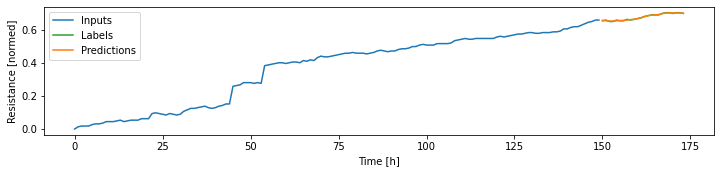

In [24]:
IPython.display.clear_output()

#multi_val_performance = model.evaluate(multi_window.val)
#multi_performance = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)

In [25]:
test_df_test.shape()

TypeError: 'tuple' object is not callable

In [ ]:
pred = model.predict(test_df_test)